Code for testing and the development of the simple bump modes scenario

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.latent_regression.scenarios import BumpInputWithRecursiveDynamicsScenario
from janelia_core.ml.latent_regression.scenarios import plot_2d_conditional_prior
from janelia_core.ml.latent_regression.scenarios import plot_2d_modes

from janelia_core.ml.latent_regression.vi import MultiSubjectVIFitter

### Parameters go here

In [3]:
n_subjects = 3
n_modes = 2
n_neuron_range = [100000, 100000]
n_dims = 2
n_smps_range = [1000, 1100]
prior_std = .001
noise_range = [.01, .02]
bump_std_range = [.1, .1]

#### See what devices are available for computation

In [4]:
if torch.cuda.is_available():
    n_cuda_devices = torch.cuda.device_count()
    print('Found ' + str(n_cuda_devices) + ' GPUs')
    devices = [torch.device('cuda:' + str(i)) for i in range(n_cuda_devices)]
    cuda_is_available = True
else:
    print('No GPUs found.  Model fitting will be done on CPU.')
    devices = [torch.device('cpu')]
    cuda_is_available = False

Found 2 GPUs


### Generate priors and subject models

In [5]:
true_mdls = BumpInputWithRecursiveDynamicsScenario(n_subjects=n_subjects, 
                                                   n_modes=n_modes, 
                                                   n_neuron_range=n_neuron_range, 
                                                   n_dims=n_dims,
                                                   prior_std=prior_std, 
                                                   noise_range=noise_range, 
                                                   bump_std_range=bump_std_range)

### View prior modes

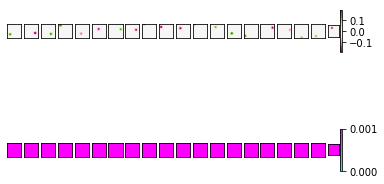

In [6]:
plot_2d_conditional_prior(true_mdls.input_u_prior)

### View modes for a given model

In [ ]:
plot_s = 0

In [ ]:
u = true_mdls.subject_mdls[plot_s].u[0].detach().numpy()
internal_p = true_mdls.subject_mdls[plot_s].p[1].detach().numpy()
neuron_p = true_mdls.subject_mdls[plot_s].neuron_pos.numpy()

In [ ]:
plot_2d_modes(modes=u, neuron_p=neuron_p)

In [ ]:
plot_2d_modes(modes=internal_p, neuron_p=neuron_p)

### Generate data from the models

In [7]:
n_smps = np.random.randint(n_smps_range[0], n_smps_range[1]+ 1, n_subjects)
subject_data = true_mdls.generate_random_input_data(n_smps, input_std=100)

### Fit one model use maximum likelihood

In [ ]:
fit_s = 0

In [ ]:
fit_data = subject_data[fit_s][0:-1]
fit_x = [t[fit_data.i_x,:] for t in fit_data.data]
fit_y = [fit_data.data[1][fit_data.i_y,:]]

In [ ]:
fit_mdl = true_mdls.generate_training_subject_mdl(fit_s)

In [ ]:
log = fit_mdl.fit(x=fit_x, y=fit_y, update_int=1000, max_its=3000, 
                          learning_rates=.001, batch_size=100, send_size=100)

#### Look at fit u modes

In [ ]:
u_fit = fit_mdl.u[0].detach().numpy()
internal_p_fit = fit_mdl.p[1].detach().numpy()
neuron_p_fit = true_mdls.subject_mdls[fit_s].neuron_pos.detach()

plot_2d_modes(modes=u_fit, neuron_p=neuron_p_fit)

In [ ]:
plot_2d_modes(modes=internal_p_fit, neuron_p=neuron_p_fit)

### Fit everything with variational inference

In [8]:
prior_dists = true_mdls.generate_fitting_priors()

In [9]:
subject_collections = [true_mdls.generate_training_collection(s_i=s_i, data=data)
                      for s_i, data in enumerate(subject_data)]

In [10]:
vi_fitter = MultiSubjectVIFitter(p_priors=prior_dists[0], u_priors=prior_dists[1], 
                                 s_collections=subject_collections)

In [11]:
vi_fitter.distribute(devices=devices)
logs=vi_fitter.fit(n_epochs=100, n_batches=10, update_int=10, 
                   learning_rates=.001, pin_memory=cuda_is_available)

*****************************************************
Epoch 0 complete.  Obj: nan, LR: 0.001
Model NLLs:  s_0: nan, s_1: nan, s_2: nan
Subj P KLs:  s_0: nan, s_1: nan, s_2: nan
Subj U KLs:  s_0: nan, s_1: nan, s_2: nan
Device memory usage:  d_0: 249428480, d_1: 800660992
Elapsed time: 15.888969659805298


KeyboardInterrupt: 

#### Look at log values

In [ ]:
plt.subplot(2,2,1)
plt.plot(logs['elapsed_time'], logs['nelbo'])
plt.title('Negative ELBO')
plt.xlabel('Elapsed Time')

plt.subplot(2,2,2)
plt.plot(logs['elapsed_time'], logs['mdl_nll'])
plt.title('Model Negative Log Likelihoods')
plt.xlabel('Elapsed Time')

plt.subplot(2,2,3)
plt.plot(logs['elapsed_time'], logs['sub_p_kl'])
plt.title('Subject P KL')
plt.xlabel('Elapsed Time')

plt.subplot(2,2,4)
plt.plot(logs['elapsed_time'], logs['sub_u_kl'])
plt.title('Subject U KL')
plt.xlabel('Elapsed Time')

#### Look at fit modes for one subject

In [ ]:
fit_s = 0
neuron_u_pos = true_mdls.subject_mdls[fit_s].neuron_pos

u_mn = subject_collections[fit_s].u_dists[0].form_standard_sample(
    subject_collections[fit_s].u_dists[0].sample(neuron_u_pos)).cpu().detach().numpy()

In [ ]:
plot_2d_modes(modes=u_mn, neuron_p=neuron_u_pos)

#### Look at prior modes

In [ ]:
plot_2d_conditional_prior(prior_dists[1][0].to('cpu'))

In [ ]:
d = torch.device('cpu')

In [ ]:
d.type == 'cpu'

In [ ]:
a = set([1, 2])

In [ ]:
set(vi_fitter.s_collection_devices + [vi_fitter.prior_device])